In [12]:
#Import needed libraries for code
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import pandas as pd
import os
import rasterstats as rs
from scipy.stats import linregress
from rasterstats import zonal_stats, point_query

In [13]:
#File paths
S2_NDCI = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/Sentinel-2_BSL_NDCI_gp.tif'
S3_NDCI = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/Sentinel-3_BSL_NDCI_gp.tif'
PS_NDCI = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/PlanetScope_BSL_NDCI_gp.tif'
sampling_points = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/23_BSL/9_11_23_loqate/9_11_23.shp'
out = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/'

In [14]:
#Functions
def rs(image, points, save=False):
    
#Open imagery, use geopandas to open point data and pull in-situ chla.
    NDCI = rio.open(image)
    SP = gpd.read_file(points)
    SP_transform = SP.to_crs(32615)
    chl = SP['Value']
    
#Naming convention to be used moving forward    
    string_split = image.split('/')
    name = string_split[-1].split('_')[0]
    
    
#Rasterstats package   
    R_ZS = zonal_stats(SP_transform, image)
    R_PQ = point_query(SP_transform, image)
    
#Setting values for dataframe
    mean = [point['mean'] for point in R_ZS]
    pixel = np.array(mean)
    chla = np.array(chl)
    ipixel = np.array(R_PQ)

#Building and cleaning dataframe    
    df = pd.DataFrame({'pixel': pixel, 'chla': chla, 'ipixel': ipixel})
    df_clean = df.dropna(subset=['pixel', 'ipixel'])
    cleaned_pixel = list(df_clean['pixel'])
    cleaned_chla = list(df_clean['chla'])
    cleaned_ipixel = list(df_clean['ipixel'])

    
#Linear regression for non-normalized and normalized data
    slope, intercept, r_value, p_value, std_err = linregress(cleaned_pixel, cleaned_chla)
    r_squared = r_value**2
    print(f'With individual pixels, p:{p_value: .3f} and r2:{r_squared}')
    
    slopei, intercepti, r_valuei, p_valuei, std_erri = linregress(cleaned_ipixel, cleaned_chla)
    r_squaredi = r_valuei**2
    print(f'With interpolated pixel values, p:{p_valuei: .3f} and r2:{r_squaredi}')
    
#Plotting of non-normalized and normalized data
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    sns.regplot(x=cleaned_pixel, y=cleaned_chla, ax=ax1)
    ax1.set_xlabel('Closest Pixel NDCI')
    ax1.set_ylabel('In-Situ Chl-a')
    ax1.text(.05, .95, f'$R^2 = {r_squared: .3f}$', transform=ax1.transAxes, verticalalignment='top', fontsize=14)
    ax1.text(.05, .88, f'$p = {p_value: .3f}$', transform=ax1.transAxes, verticalalignment='top', fontsize=14)
    
    sns.regplot(x=cleaned_ipixel, y=cleaned_chla, ax=ax2)
    ax2.set_xlabel('Pixel Interpolation NDCI')
    ax2.set_ylabel('In-Situ Chl-a')
    ax2.text(.05, .95, f'$R^2 = {r_squaredi: .3f}$', transform=ax2.transAxes, verticalalignment='top', fontsize=14)
    ax2.text(.05, .88, f'$p = {p_valuei: .3f}$', transform=ax2.transAxes, verticalalignment='top', fontsize=14)
    
    fig.suptitle(f'{name} NDCI Comparison', fontsize=16, fontweight = 'bold')
    plt.tight_layout()
    
#Save function
    if save == True:
        plt.savefig(os.path.join(out, f'{name}_NDCI_comparison'), dpi=1200, bbox_inches='tight')
    plt.show()

With individual pixels, p: 0.053 and r2:0.16653903180106835
With interpolated pixel values, p: 0.253 and r2:0.0616140159005133


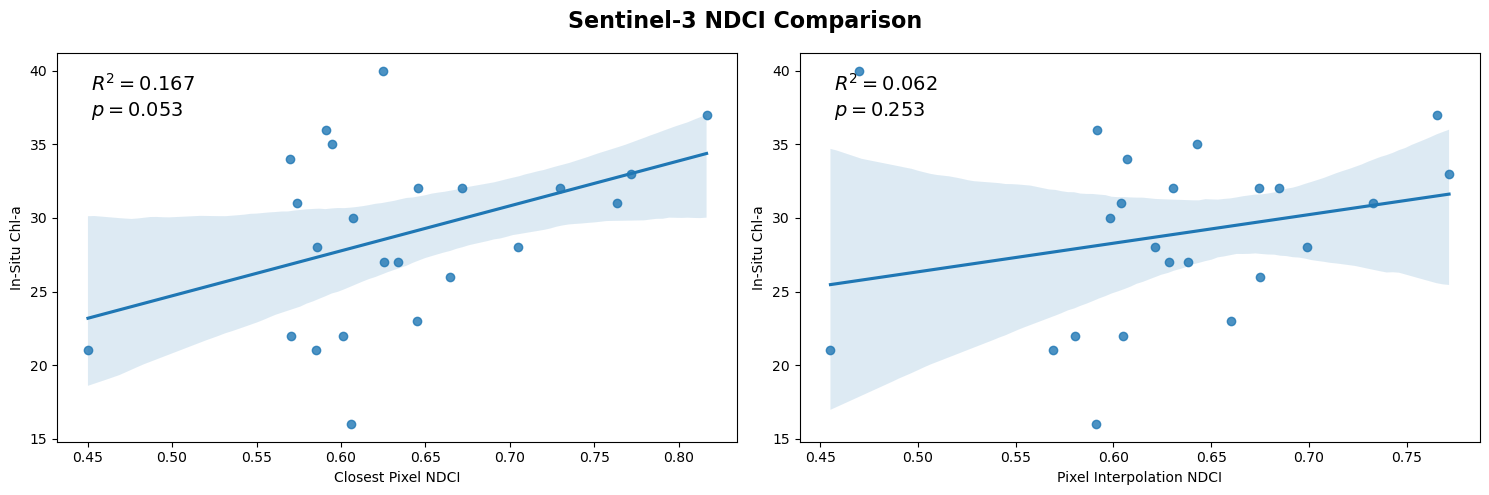

In [15]:
raster_analysis = rs(S3_NDCI, sampling_points, save=False)